Alignment checking and EDA

Cell 0 — Init, env, add src/ to path, locate RVTALL

In [7]:
# Colab Starter — Set base, validate data, and run lightweight EDA

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

'''
def add_src_to_sys_path(start: Path | None = None) -> Path:
    """Find the nearest folder containing 'src' and add it to sys.path."""
    here = Path(start or Path.cwd()).resolve()
    for parent in (here, *here.parents):
        src = parent / "src"
        if src.is_dir():
            if str(src) not in sys.path:
                sys.path.insert(0, str(src))
            print("✅ Added to sys.path:", src)
            return src
    raise FileNotFoundError("Could not find a 'src' directory above this notebook.")

SRC_DIR = add_src_to_sys_path()
'''

def add_project_root_to_sys_path(start: Path | None = None) -> Path:
    """Find the nearest parent folder containing a `src` directory and add it to sys.path."""
    here = Path(start or Path.cwd()).resolve()
    for parent in (here, *here.parents):
        if (parent / 'src').is_dir():
            if str(parent) not in sys.path:
                sys.path.insert(0, str(parent))
                print(f"✅ Added to sys.path: {parent}")
            return parent
    raise FileNotFoundError("Could not find a parent directory containing a `src` directory above this notebook.")

PROJECT_ROOT = add_project_root_to_sys_path()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Added to sys.path: C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal


Cell 1 — Imports, base discovery, quick counts

In [9]:
import os, math, random, warnings, json
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.io import wavfile, loadmat

from src.utils.rvtall_io import (
    find_rvtall_base, list_sets, list_corpora_dirs, corpus_type,
    resolve_corpus_dir, kinect_pair_index_paths, kinect_first_pair,
    load_audio_env, load_lip_aperture_csv, first_npy, load_npy, zscore
)

from src.scripts.validate_rvtall import (
    summarize, list_unexpected_files
)

# Set seeds, print options, suppress warnings
random.seed(123)
np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

BASE = find_rvtall_base(Path.cwd())
print("RVTALL base:", BASE)

#just calling summarize from scripts.rvtall_validate to print out summary: 

summarize(BASE)
list_unexpected_files(BASE)

'''
# fast sanity counts (doesn't traverse all frames)
"""Count files quickly using glob patterns. Only accurate for audio wavs, the rest (mouth pngs, radar/uwb/laser are 0)"""
def fast_counts(BASE: Path):
    root = str(BASE)
    audio_wavs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "audios", "audio_proc_*.wav"))) \
                 + len(glob(os.path.join(root, "kinect_processed", "*", "*", "audio_proc_*.wav")))
    mouth_pngs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "videos", "video_*", "mouth", "*.png"))) \
                 + len(glob(os.path.join(root, "kinect_processed", "*", "*", "mouth", "*.png")))
    radar_npys = len(glob(os.path.join(root, "radar_processed", "*", "*", "sample_*.npy")))
    uwb_npys   = len(glob(os.path.join(root, "uwb_processed",   "*", "*", "sample_*.npy")))
    laser_npys = len(glob(os.path.join(root, "laser_processed", "*", "*", "sample_*.npy")))
    return audio_wavs, mouth_pngs, radar_npys, uwb_npys, laser_npys

audio_wavs, mouth_pngs, radar_npys, uwb_npys, laser_npys = fast_counts(BASE)
print(f"audio wavs : {audio_wavs}")
print(f"mouth pngs : {mouth_pngs}")
print(f"radar npy  : {radar_npys}")
print(f"uwb npy    : {uwb_npys}")
print(f"laser npy  : {laser_npys}")
'''



RVTALL base: C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data
audio wavs : 5300
mouth pngs : 468617
radar npy  : 4956
uwb npy    : 10538
laser npy  : 5091
[OK] Total files indexed: 494502
[!] 5 unexpected file(s) found (first 10 shown):
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\kinect_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\laser_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\radar_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\uwb_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\uwb_processed\10\vowel_1.7z


'\n# fast sanity counts (doesn\'t traverse all frames)\n"""Count files quickly using glob patterns. Only accurate for audio wavs, the rest (mouth pngs, radar/uwb/laser are 0)"""\ndef fast_counts(BASE: Path):\n    root = str(BASE)\n    audio_wavs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "audios", "audio_proc_*.wav")))                  + len(glob(os.path.join(root, "kinect_processed", "*", "*", "audio_proc_*.wav")))\n    mouth_pngs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "videos", "video_*", "mouth", "*.png")))                  + len(glob(os.path.join(root, "kinect_processed", "*", "*", "mouth", "*.png")))\n    radar_npys = len(glob(os.path.join(root, "radar_processed", "*", "*", "sample_*.npy")))\n    uwb_npys   = len(glob(os.path.join(root, "uwb_processed",   "*", "*", "sample_*.npy")))\n    laser_npys = len(glob(os.path.join(root, "laser_processed", "*", "*", "sample_*.npy")))\n    return audio_wavs, mouth_pngs, radar_npys, uwb_npys, laser_npys\n

Cell 2 — Core helpers (lag, resampling, compact feature functions)

In [ ]:
def rms_envelope(x, win):
    if win <= 1: return np.abs(x)
    k = np.ones(win)/win
    return np.sqrt(np.convolve(x**2, k, mode="same"))

def find_lag(a, b):
    """Return lag in samples that best aligns a to b (positive => a lags b)."""
    a, b = zscore(a), zscore(b)
    corr = correlate(a, b, mode="full")
    lag = np.argmax(corr) - (len(b) - 1)
    return lag

def resample_to_len(x, L):
    return np.interp(np.linspace(0,1,L), np.linspace(0,1,len(x)), x)

def lip_aperture(csv_path, upper_idx=51, lower_idx=57):
    la = load_lip_aperture_csv(csv_path, upper_idx, lower_idx)
    return la

def lip_aperture_multiaxis(csv_path):
    df = pd.read_csv(csv_path)
    upper = df[['upper_lip_y', 'upper_lip_x', 'upper_lip_z']].to_numpy()
    lower = df[['lower_lip_y', 'lower_lip_x', 'lower_lip_z']].to_numpy()
    # Euclidean distance between centroids of upper/lower lip landmarks
    return np.linalg.norm(upper - lower, axis=1)


def audio_envelope(wav_path, rms_ms=20):
    ae, t, fs = load_audio_env(wav_path, rms_ms)
    return ae, t, fs

def multimodal_align(BASE, set_id, corpus):
    modes = {}
    for mode in ['laser','radar','uwb']:
        f = first_npy(BASE, mode, set_id, corpus)
        if f:
            sig = zscore(np.asarray(load_npy(f)).squeeze())
            modes[mode] = sig
    return modes



Cell 3 — Single sample overlay (Audio vs Lip), optional Laser/Radar

Resolved word5 → using pair index 0
  audio: audio_proc_0.wav
  land : land_proc_0.csv


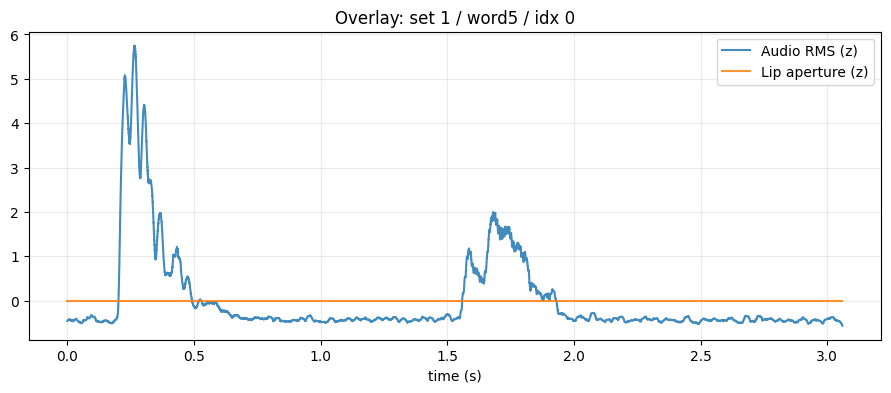

No laser sample_*.npy for this corpus.
No radar sample_*.npy for this corpus.


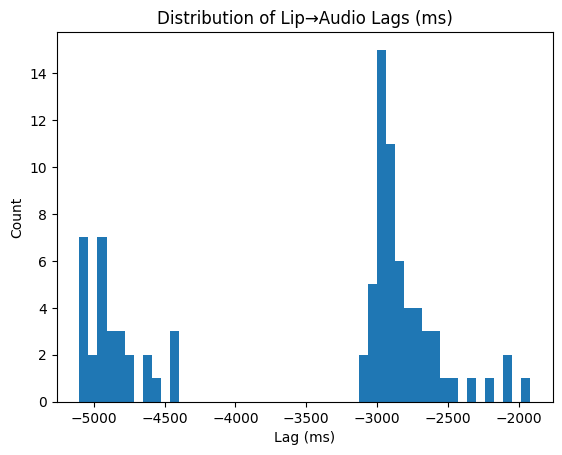

In [ ]:
# Choose a sample; name can be 'word5', 'word_5', 'sentences1', etc.
set_id = "1"
corpus = "word5"

cdir = resolve_corpus_dir(BASE, set_id, corpus)
assert cdir is not None, f"Could not resolve corpus dir for {set_id}/{corpus}"

first = kinect_first_pair(BASE, set_id, cdir)
assert first is not None, f"No (audio, landmark) pairs found in {cdir}"
idx, wav_path, csv_path = first
print(f"Resolved {cdir.name} → using pair index {idx}\n  audio: {wav_path.name}\n  land : {csv_path.name}")

audio_env, t_audio, fs = audio_envelope(wav_path, rms_ms=20)
lip = lip_aperture(csv_path)
t_lip = np.linspace(0.0, t_audio[-1], len(lip))

ae, la = zscore(audio_env), zscore(lip)

plt.figure(figsize=(11,4))
plt.plot(t_audio, ae, label="Audio RMS (z)", alpha=0.85)
plt.plot(t_lip,   la, label="Lip aperture (z)", alpha=0.85)
plt.title(f"Overlay: set {set_id} / {cdir.name} / idx {idx}")
plt.xlabel("time (s)"); plt.legend(); plt.grid(True, alpha=0.25); plt.show()


lags = []
for _,row in df.iterrows():
    lags.append(row["lag_lip_to_audio_ms"])
plt.hist(lags, bins=50)
plt.title("Distribution of Lip→Audio Lags (ms)")
plt.xlabel("Lag (ms)"); plt.ylabel("Count")

#lag_samples = find_lag(la, ae)
# lag_ms = 1000.0 * lag_samples / fs
#print(f"Estimated lip→audio lag: {lag_ms:.1f} ms (positive => lips lag audio)")

# Optional: Laser and Radar (first sample_*.npy)
laser = first_npy(BASE, "laser", set_id, cdir)
radar = first_npy(BASE, "radar", set_id, cdir)

if laser:
    L = load_npy(laser); Lz = zscore(np.asarray(L).squeeze())
    tL = np.linspace(0, t_audio[-1], len(Lz))
    plt.figure(figsize=(11,3))
    plt.plot(t_audio, ae, label="Audio RMS (z)", alpha=0.7)
    plt.plot(tL, Lz, label=f"Laser (z) [{laser.name}]", alpha=0.7)
    plt.title("Audio vs Laser"); plt.legend(); plt.grid(True, alpha=0.25); plt.show()
else:
    print("No laser sample_*.npy for this corpus.")

if radar:
    R = load_npy(radar); Rz = zscore(np.asarray(R).squeeze())
    tR = np.linspace(0, t_audio[-1], len(Rz))
    plt.figure(figsize=(11,3))
    plt.plot(t_audio, ae, label="Audio RMS (z)", alpha=0.7)
    plt.plot(tR, Rz, label=f"Radar (z) [{radar.name}]", alpha=0.7)
    plt.title("Audio vs Radar"); plt.legend(); plt.grid(True, alpha=0.25); plt.show()
else:
    print("No radar sample_*.npy for this corpus.")


Cell 4 — Aggregated sampling (compact stats into DataFrames)

Goals:

don’t sweep the whole dataset; cap per semantic type

build a tidy per-pair table for audio↔lip lags (optionally note presence of laser/radar)

quick summary by semantic type

In [11]:
from collections import defaultdict

def lag_lip_audio_for_pair(wav_path, csv_path, rms_ms=20):
    ae, _, fs_ = audio_envelope(wav_path, rms_ms)
    la = lip_aperture(csv_path)
    la = resample_to_len(la, len(ae))
    lag_ms = 1000.0 * find_lag(zscore(la), zscore(ae)) / fs_
    return lag_ms

def sample_pairs_dataframe(BASE, set_ids=("1","2","3","4"), per_type_cap=30):
    rows = []
    caps = defaultdict(int)  # count per semantic type
    for sid in set_ids:
        for cdir in list_corpora_dirs(BASE, sid):
            sem = corpus_type(cdir.name)
            if sem not in ("vowel","word","sentence"):
                continue
            if caps[sem] >= per_type_cap:
                continue

            pairs = kinect_pair_index_paths(cdir)
            if not pairs:
                continue

            # sample up to a few pairs per corpus to stay light
            for (idx, wav, csv) in pairs[:3]:
                try:
                    lag_ms = lag_lip_audio_for_pair(wav, csv)
                except Exception as e:
                    continue

                has_laser = first_npy(BASE, "laser", sid, cdir) is not None
                has_radar = first_npy(BASE, "radar", sid, cdir) is not None
                has_uwb   = first_npy(BASE, "uwb",   sid, cdir) is not None

                rows.append({
                    "set_id": sid,
                    "corpus": cdir.name,
                    "semantic": sem,
                    "pair_idx": idx,
                    "lag_lip_to_audio_ms": float(lag_ms),
                    "has_laser": has_laser,
                    "has_radar": has_radar,
                    "has_uwb": has_uwb
                })

                caps[sem] += 1
                if caps[sem] >= per_type_cap:
                    break
    return pd.DataFrame(rows)

df = sample_pairs_dataframe(BASE, set_ids=tuple(map(str, range(1,5))), per_type_cap=30)
print("rows:", len(df))
display(df.head(10))

summary = df.groupby("semantic")["lag_lip_to_audio_ms"].agg(["count","mean","std","min","max"]).reset_index()
print("\nSummary by semantic:")
display(summary)


rows: 90


,set_id,corpus,semantic,pair_idx,lag_lip_to_audio_ms,has_laser,has_radar,has_uwb
0,1,sentences1,sentence,0,-4559.9375,False,False,False
1,1,sentences1,sentence,1,-4919.9375,False,False,False
2,1,sentences1,sentence,2,-4799.9375,False,False,False
3,1,sentences10,sentence,0,-5039.9375,False,False,False
4,1,sentences10,sentence,1,-5099.9375,False,False,False
5,1,sentences10,sentence,2,-4439.9375,False,False,False
6,1,sentences2,sentence,0,-4859.9375,False,False,False
7,1,sentences2,sentence,1,-4619.9375,False,False,False
8,1,sentences2,sentence,2,-5039.9375,False,False,False
9,1,sentences3,sentence,0,-4799.9375,False,False,False



Summary by semantic:


,semantic,count,mean,std,min,max
0,sentence,30,-4843.937500,192.292880,-5099.9375,-4439.9375
1,vowel,30,-2683.029167,289.997338,-3119.9375,-1919.9375
2,word,30,-2915.937500,135.178044,-3119.9375,-2459.9375


Cell 5 — Visual summaries (hist, boxplot, alignment score)

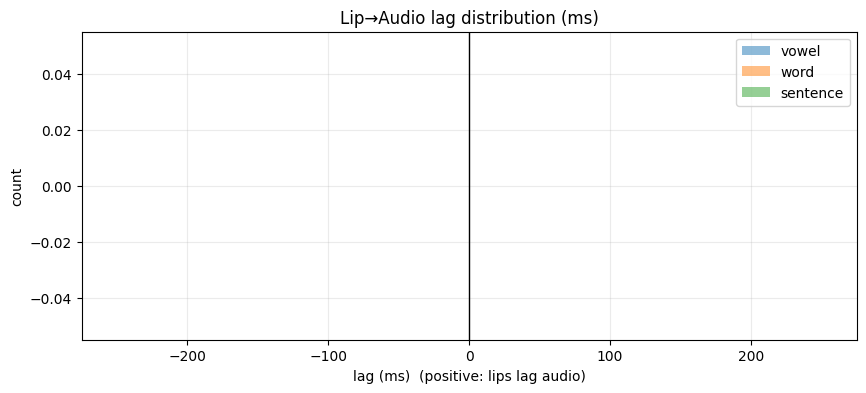

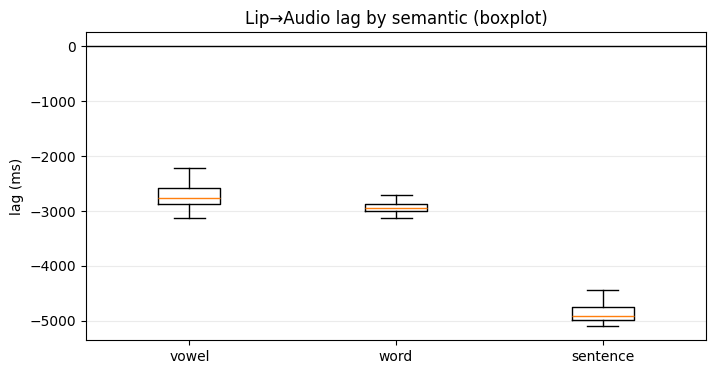

Alignment within ±50 ms: {'vowel': np.float64(0.0), 'word': np.float64(0.0), 'sentence': np.float64(0.0)}
Alignment within ±100 ms: {'vowel': np.float64(0.0), 'word': np.float64(0.0), 'sentence': np.float64(0.0)}
Alignment within ±150 ms: {'vowel': np.float64(0.0), 'word': np.float64(0.0), 'sentence': np.float64(0.0)}


In [15]:
# Histogram by semantic type
plt.figure(figsize=(10,4))
bins = np.linspace(-250, 250, 51)
for sem in ["vowel","word","sentence"]:
    vals = df.loc[df.semantic==sem, "lag_lip_to_audio_ms"].values
    if len(vals):
        plt.hist(vals, bins=bins, alpha=0.5, label=sem)
plt.axvline(0, color="k", lw=1)
plt.title("Lip→Audio lag distribution (ms)")
plt.xlabel("lag (ms)  (positive: lips lag audio)"); plt.ylabel("count")
plt.legend(); plt.grid(True, alpha=0.25); plt.show()

# Boxplot (matplotlib only)
data = [df.loc[df.semantic==sem, "lag_lip_to_audio_ms"].values for sem in ["vowel","word","sentence"] if (df.semantic==sem).any()]
labels = [sem for sem in ["vowel","word","sentence"] if (df.semantic==sem).any()]
plt.figure(figsize=(8,4))
plt.boxplot(data, labels=labels, showfliers=False)
plt.axhline(0, color="k", lw=1)
plt.ylabel("lag (ms)"); plt.title("Lip→Audio lag by semantic (boxplot)")
plt.grid(True, axis="y", alpha=0.25); plt.show()

# Alignment score: % pairs within ±X ms
def alignment_score(df, tol_ms=100.0):
    out = {}
    for sem in ["vowel","word","sentence"]:
        sub = df[df.semantic==sem]["lag_lip_to_audio_ms"].values
        if len(sub):
            pct = 100.0 * np.mean(np.abs(sub) <= tol_ms)
            out[sem] = pct
    return out

print("Alignment within ±50 ms:", alignment_score(df, 50.0))
print("Alignment within ±100 ms:", alignment_score(df, 100.0))
print("Alignment within ±150 ms:", alignment_score(df, 150.0))


Cell 6: Laser/Radar for more quick correlations

In [16]:
# Cross-modal sanity: correlate audio envelope with laser/radar envelopes
# (keep it *very* light: sample N=10 rows which have that modality)

def envelope_like(x, target_len):
    x = np.asarray(x).squeeze()
    x = (x - x.mean())/(x.std() if x.std()>1e-8 else 1.0)
    return resample_to_len(x, target_len)

def pair_corr(a, b):
    a, b = zscore(a), zscore(b)
    corr = np.corrcoef(a, b)[0,1]
    return float(corr)

def small_cross_modal_checks(df, BASE, max_rows=10):
    res = []
    taken = 0
    for _, r in df.iterrows():
        if taken >= max_rows:
            break
        sid, c = r["set_id"], r["corpus"]
        cdir = resolve_corpus_dir(BASE, sid, c)
        if cdir is None: 
            continue

        first = kinect_first_pair(BASE, sid, cdir)
        if not first: 
            continue
        idx, wav, csv = first

        ae, _, fs = audio_envelope(wav, 20)

        if r["has_laser"]:
            Lp = first_npy(BASE, "laser", sid, cdir)
            if Lp:
                L = load_npy(Lp)
                Lenv = envelope_like(L, len(ae))
                res.append({"set_id":sid, "corpus":c, "mod":"laser", "corr_audio": pair_corr(ae, Lenv)})

        if r["has_radar"]:
            Rp = first_npy(BASE, "radar", sid, cdir)
            if Rp:
                R = load_npy(Rp)
                Renv = envelope_like(R, len(ae))
                res.append({"set_id":sid, "corpus":c, "mod":"radar", "corr_audio": pair_corr(ae, Renv)})
        taken += 1
    return pd.DataFrame(res)

df_corr = small_cross_modal_checks(df, BASE, max_rows=10)
print("cross-modal rows:", len(df_corr))
display(df_corr)
if len(df_corr):
    print("Mean corr by modality:")
    display(df_corr.groupby("mod")["corr_audio"].mean().to_frame("mean_corr"))



cross-modal rows: 0


""


Cell 7 — (Optional) Save mean offsets per corpus (light)

(Keeps it small: only for corpora already sampled into df)

In [ ]:
# per (set_id, corpus) mean — *only* on the sampled rows already in df*
offsets = (df.groupby(["set_id","corpus"])["lag_lip_to_audio_ms"]
             .mean().astype(float).to_dict())

print("Offsets saved for", len(offsets), "corpora (sampled set).")
Path("outputs").mkdir(parents=True, exist_ok=True)
np.save("outputs/rvtall_lip_to_audio_offsets_ms.npy", offsets, allow_pickle=True)


Cell 8 — (Optional) Training CLI stub (run after you’re happy with alignment)

In [17]:
# When ready to train (from repo root):
# !python -m src.training.train_contrastive --config src/configs/rvtall_contrastive.yaml

Cell 9 — (Optional) Colab compute notes

In [ ]:
# Only if running on Colab:
"""
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!git clone <HTTPS goes here>
%cd silentSpeech 
%pip install -r requirements.txt

# If your RVTALL lives in Drive:
# BASE = Path('/content/drive/MyDrive/RVTALL/Processed_cut_data')
"""
